<a href="https://colab.research.google.com/github/minjaecd123/study/blob/master/20250328_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/syon/merge_trends_weather_long_ml.csv')
df

,Date,GroupName,Gender,Age_Group,Search_Count,STN,Temperature,Humidity,Precipitation,Snowfall
0,2023-01-01,찌개/국/탕,m,청년층,52.20577,108,-0.2,54.5,-9.0,-9.0
1,2023-01-01,찌개/국/탕,m,청년층,52.20577,119,-2.1,63.1,-9.0,-9.0
2,2023-01-01,찌개/국/탕,m,청년층,52.20577,105,4.8,31.6,-9.0,-9.0
3,2023-01-01,찌개/국/탕,m,청년층,52.20577,131,-0.3,54.1,-9.0,-9.0
4,2023-01-01,찌개/국/탕,m,청년층,52.20577,133,-0.8,54.1,-9.0,-9.0
...,...,...,...,...,...,...,...,...,...,...
276313,2024-12-31,안주/보양식,f,장년층,20.95851,133,2.3,44.1,-9.0,-9.0
276314,2024-12-31,안주/보양식,f,장년층,20.95851,156,4.1,54.9,-9.0,-9.0
276315,2024-12-31,안주/보양식,f,장년층,20.95851,143,4.2,32.5,-9.0,-9.0
276316,2024-12-31,안주/보양식,f,장년층,20.95851,159,6.7,27.5,-9.0,-9.0


✅ 정확도(Accuracy): 0.8447619047619047

📊 분류 리포트:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       317
           1       0.84      0.83      0.83       218
           2       0.94      0.96      0.95       141
           3       0.80      0.82      0.81       374

    accuracy                           0.84      1050
   macro avg       0.86      0.86      0.86      1050
weighted avg       0.85      0.84      0.84      1050



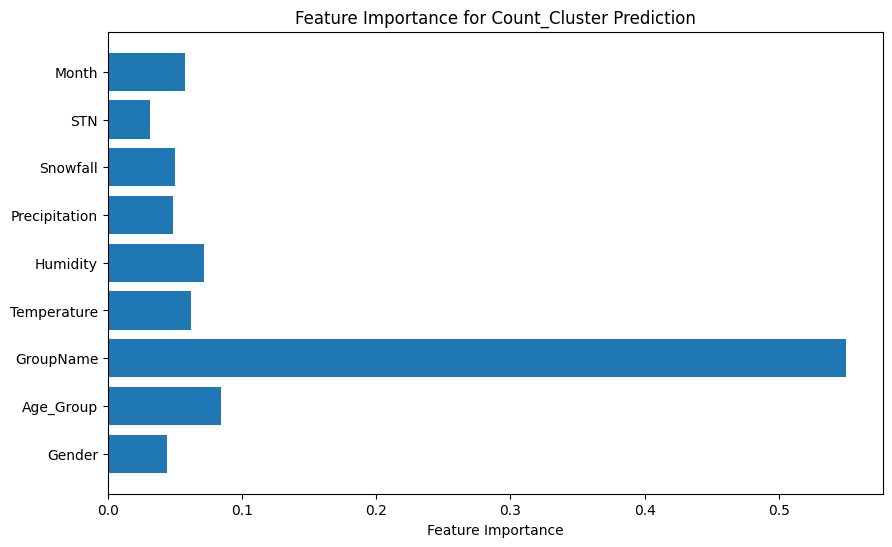


🍽️ 추천 음식군 (예측된 클러스터 기반):
1. 간편식
2. 볶음/구이
3. 브런치/샐러드


In [13]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/syon/merge_trends_weather_long_ml.csv')

# 2. 날짜 처리 → Month 생성 후 Date 제거
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df.drop(columns=['Date'], inplace=True)

# 3. 결측값 처리 (-9.0 → NA → 제거)
df.replace(-9.0, pd.NA, inplace=True)
df.dropna(inplace=True)

# 4. 로그 변환
df['Search_Count_Log'] = np.log1p(df['Search_Count'])

# 5. 클러스터링 (KMeans로 Search_Count_Log 기준 클러스터 생성)
kmeans = KMeans(n_clusters=4, random_state=42)
df['Count_Cluster'] = kmeans.fit_predict(df[['Search_Count_Log']])

# 6. 범주형 변수 인코딩
label_cols = ['Gender', 'Age_Group', 'GroupName']
label_encoders = {}

for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # 나중에 역변환용 저장

# 7. 입력 변수 및 타깃 지정
features = ['Gender', 'Age_Group', 'GroupName', 'Temperature', 'Humidity',
            'Precipitation', 'Snowfall', 'STN', 'Month']
target = 'Count_Cluster'

X = df[features]
y = df[target]

# 8. 분할 및 학습
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 9. 평가
y_pred = clf.predict(X_test)
print("✅ 정확도(Accuracy):", accuracy_score(y_test, y_pred))
print("\n📊 분류 리포트:")
print(classification_report(y_test, y_pred))

# 10. 중요 변수 시각화
importances = clf.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X.columns, importances)
plt.xlabel("Feature Importance")
plt.title("Feature Importance for Count_Cluster Prediction")
plt.show()

# 11. 추천 함수
def recommend_from_cluster(user_input: dict, clf_model, df_with_clusters):
    row = pd.DataFrame([user_input])
    # 인코딩
    for col in ['Gender', 'Age_Group', 'GroupName']:
        row[col] = label_encoders[col].transform(row[col])

    # 클러스터 예측
    predicted_cluster = clf_model.predict(row)[0]

    # 클러스터 내에서 평균 검색량 높은 음식군 상위 3개 추출
    top_groups = (
        df_with_clusters[df_with_clusters['Count_Cluster'] == predicted_cluster]
        .groupby('GroupName')['Search_Count']
        .mean()
        .sort_values(ascending=False)
        .head(3)
        .index
    )

    return label_encoders['GroupName'].inverse_transform(top_groups)

# 12. 추천 예시 입력
user_input_example = {
    'Gender': 'm',
    'Age_Group': '청년층',
    'GroupName': '찌개/국/탕',  # 아무 음식군으로 넣어도 클러스터 예측에만 쓰임
    'Temperature': 3.2,
    'Humidity': 60.0,
    'Precipitation': 0.0,
    'Snowfall': 0.0,
    'STN': 108,
    'Month': 1
}

# 13. 추천 실행
recommendations = recommend_from_cluster(user_input_example, clf, df)
print("\n🍽️ 추천 음식군 (예측된 클러스터 기반):")
for i, food in enumerate(recommendations, 1):
    print(f"{i}. {food}")


✅ 정확도(Accuracy): 0.8447619047619047

📊 분류 리포트:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       317
           1       0.84      0.83      0.83       218
           2       0.94      0.96      0.95       141
           3       0.80      0.82      0.81       374

    accuracy                           0.84      1050
   macro avg       0.86      0.86      0.86      1050
weighted avg       0.85      0.84      0.84      1050



<ipython-input-14-b814f4b356d3>:79: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


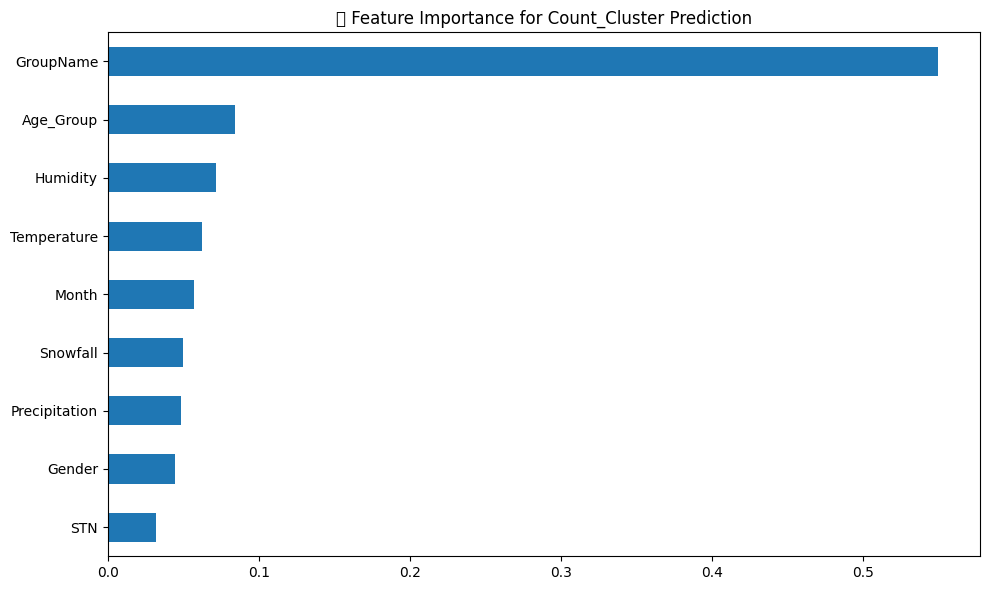


📊 클러스터별 평균 검색량:
Count_Cluster
2    14.045795
1    31.730561
3    49.797986
0    73.110373
Name: Search_Count, dtype: float64

🍽️ 추천 음식군 (예측된 클러스터 기반):
1. 간편식
2. 볶음/구이
3. 브런치/샐러드


In [14]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# -----------------------------
# 1. 데이터 불러오기
# -----------------------------
df = pd.read_csv('/content/drive/MyDrive/syon/merge_trends_weather_long_ml.csv')

# -----------------------------
# 2. 날짜 처리
# -----------------------------
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df.drop(columns=['Date'], inplace=True)

# -----------------------------
# 3. 결측값 처리
# -----------------------------
df.replace(-9.0, pd.NA, inplace=True)
df.dropna(inplace=True)

# -----------------------------
# 4. 로그 변환 + 클러스터링
# -----------------------------
df['Search_Count_Log'] = np.log1p(df['Search_Count'])

kmeans = KMeans(n_clusters=4, random_state=42)
df['Count_Cluster'] = kmeans.fit_predict(df[['Search_Count_Log']])

# -----------------------------
# 5. 범주형 변수 인코딩
# -----------------------------
label_cols = ['Gender', 'Age_Group', 'GroupName']
label_encoders = {}

for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # 나중에 디코딩용 저장

# -----------------------------
# 6. 분류 모델 학습 (RandomForestClassifier)
# -----------------------------
features = ['Gender', 'Age_Group', 'GroupName', 'Temperature', 'Humidity',
            'Precipitation', 'Snowfall', 'STN', 'Month']
target = 'Count_Cluster'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# -----------------------------
# 7. 성능 평가
# -----------------------------
y_pred = clf.predict(X_test)

print("✅ 정확도(Accuracy):", accuracy_score(y_test, y_pred))
print("\n📊 분류 리포트:")
print(classification_report(y_test, y_pred))

# -----------------------------
# 8. 변수 중요도 시각화
# -----------------------------
importances = clf.feature_importances_
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='barh')
plt.title("🎯 Feature Importance for Count_Cluster Prediction")
plt.tight_layout()
plt.show()

# -----------------------------
# 9. 클러스터 중심 해석
# -----------------------------
cluster_summary = df.groupby('Count_Cluster')['Search_Count'].mean().sort_values()
print("\n📊 클러스터별 평균 검색량:")
print(cluster_summary)

# -----------------------------
# 10. 추천 함수 정의
# -----------------------------
def recommend_from_cluster(user_input: dict, clf_model, df_with_clusters, label_encs):
    row = pd.DataFrame([user_input])
    for col in ['Gender', 'Age_Group', 'GroupName']:
        row[col] = label_encs[col].transform(row[col])

    predicted_cluster = clf_model.predict(row)[0]

    top_groups = (
        df_with_clusters[df_with_clusters['Count_Cluster'] == predicted_cluster]
        .groupby('GroupName')['Search_Count']
        .mean()
        .sort_values(ascending=False)
        .head(3)
        .index
    )

    return label_encs['GroupName'].inverse_transform(top_groups)

# -----------------------------
# 11. 사용자 입력 예시
# -----------------------------
user_input = {
    'Gender': 'm',
    'Age_Group': '청년층',
    'GroupName': '찌개/국/탕',  # 아무거나 입력 (클러스터 예측에만 필요)
    'Temperature': 3.2,
    'Humidity': 60.0,
    'Precipitation': 0.0,
    'Snowfall': 0.0,
    'STN': 108,
    'Month': 1
}

recommendations = recommend_from_cluster(user_input, clf, df, label_encoders)

print("\n🍽️ 추천 음식군 (예측된 클러스터 기반):")
for i, food in enumerate(recommendations, 1):
    print(f"{i}. {food}")


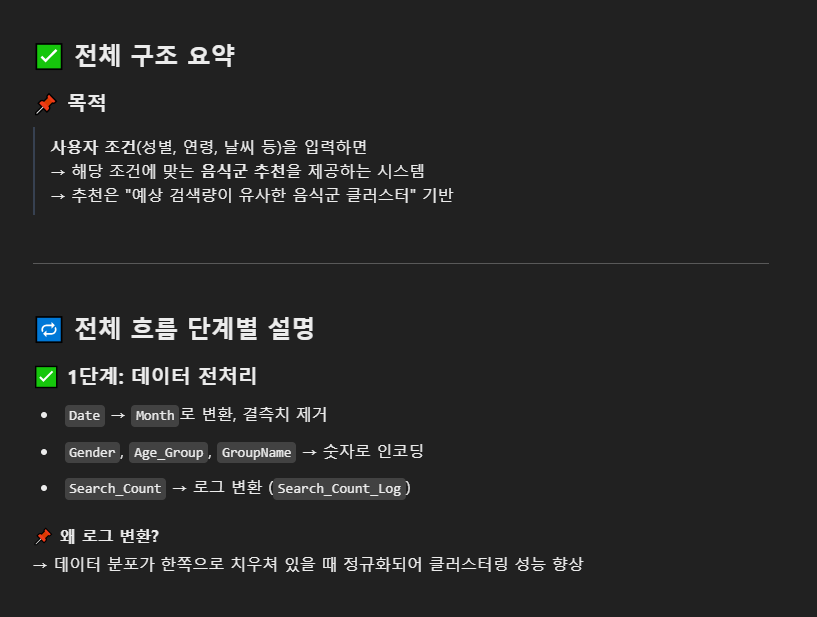

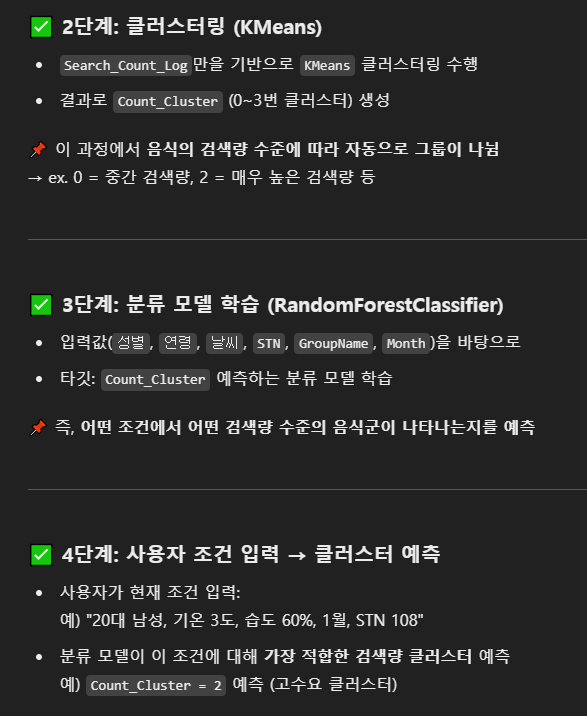

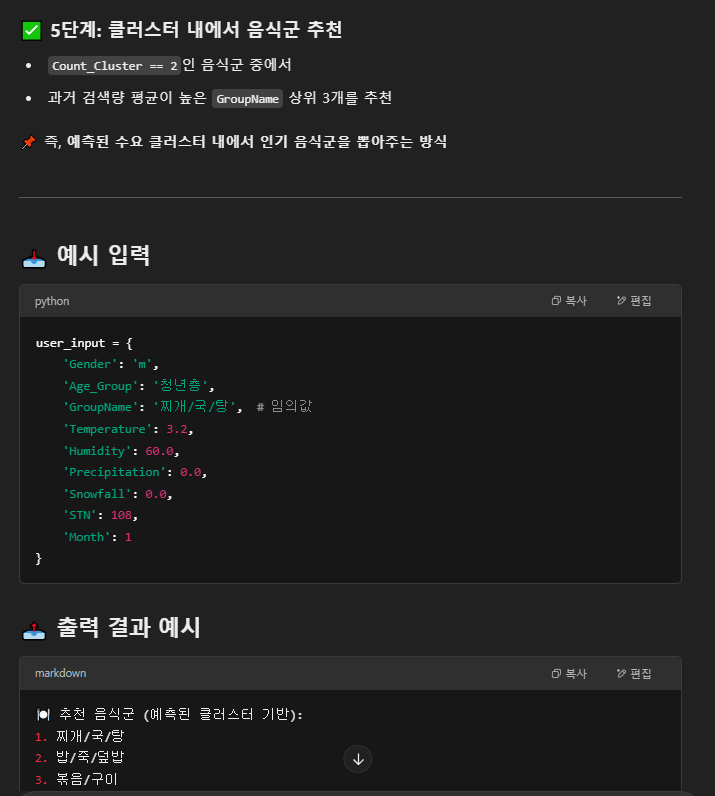

# GroupName 제거 ✅ 정확도(Accuracy): 0.3838095238095238

✅ 정확도(Accuracy): 0.3838095238095238

📊 분류 리포트:
              precision    recall  f1-score   support

           0       0.45      0.51      0.48       317
           1       0.28      0.28      0.28       218
           2       0.00      0.00      0.00       141
           3       0.40      0.48      0.44       374

    accuracy                           0.38      1050
   macro avg       0.28      0.32      0.30      1050
weighted avg       0.34      0.38      0.36      1050



<ipython-input-16-17bc13809c1a>:79: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


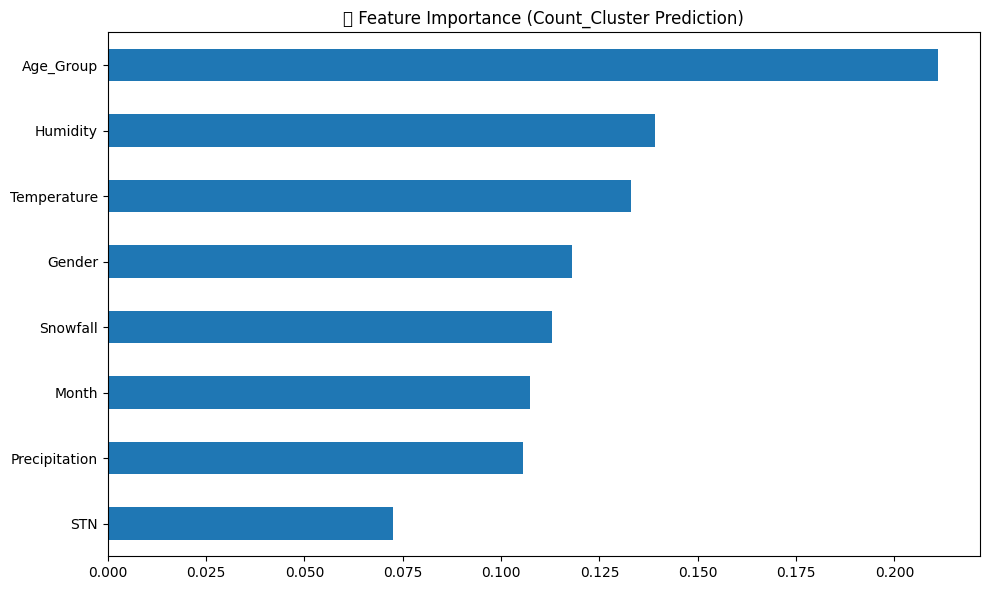


📊 클러스터별 평균 검색량:
Count_Cluster
2    14.045795
1    31.730561
3    49.797986
0    73.110373
Name: Search_Count, dtype: float64

🍽️ 추천 음식군 (예측된 클러스터 기반):
1. 밥/죽/덮밥
2. 간편식
3. 브런치/샐러드


In [16]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# -----------------------------
# 1. 데이터 불러오기
# -----------------------------
df = pd.read_csv('/content/drive/MyDrive/syon/merge_trends_weather_long_ml.csv')

# -----------------------------
# 2. 날짜 처리
# -----------------------------
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df.drop(columns=['Date'], inplace=True)

# -----------------------------
# 3. 결측값 처리
# -----------------------------
df.replace(-9.0, pd.NA, inplace=True)
df.dropna(inplace=True)

# -----------------------------
# 4. 로그 변환 + 클러스터링
# -----------------------------
df['Search_Count_Log'] = np.log1p(df['Search_Count'])

kmeans = KMeans(n_clusters=4, random_state=42)
df['Count_Cluster'] = kmeans.fit_predict(df[['Search_Count_Log']])

# -----------------------------
# 5. 범주형 변수 인코딩
# -----------------------------
label_cols = ['Gender', 'Age_Group', 'GroupName']
label_encoders = {}

for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# -----------------------------
# 6. 분류 모델 학습 (GroupName 제외)
# -----------------------------
features = ['Gender', 'Age_Group', 'Temperature', 'Humidity',
            'Precipitation', 'Snowfall', 'STN', 'Month']
target = 'Count_Cluster'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# -----------------------------
# 7. 성능 평가
# -----------------------------
y_pred = clf.predict(X_test)

print("✅ 정확도(Accuracy):", accuracy_score(y_test, y_pred))
print("\n📊 분류 리포트:")
print(classification_report(y_test, y_pred))

# -----------------------------
# 8. 변수 중요도 시각화
# -----------------------------
importances = clf.feature_importances_
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='barh')
plt.title("🎯 Feature Importance (Count_Cluster Prediction)")
plt.tight_layout()
plt.show()

# -----------------------------
# 9. 클러스터별 평균 검색량 보기
# -----------------------------
cluster_summary = df.groupby('Count_Cluster')['Search_Count'].mean().sort_values()
print("\n📊 클러스터별 평균 검색량:")
print(cluster_summary)

# -----------------------------
# 10. 추천 함수 정의 (GroupName 없이 입력)
# -----------------------------
def recommend_from_cluster(user_input: dict, clf_model, df_with_clusters, label_encs):
    row = pd.DataFrame([user_input])
    for col in ['Gender', 'Age_Group']:
        row[col] = label_encs[col].transform(row[col])

    predicted_cluster = clf_model.predict(row)[0]

    top_groups = (
        df_with_clusters[df_with_clusters['Count_Cluster'] == predicted_cluster]
        .groupby('GroupName')['Search_Count']
        .mean()
        .sort_values(ascending=False)
        .head(3)
        .index
    )

    return label_encs['GroupName'].inverse_transform(top_groups)

# -----------------------------
# 11. 사용자 입력 예시 (GroupName 제외)
# -----------------------------
user_input = {
    'Gender': 'm',
    'Age_Group': '청년층',
    'Temperature': 3.2,
    'Humidity': 60.0,
    'Precipitation': 0.0,
    'Snowfall': 0.0,
    'STN': 108,
    'Month': 1
}

recommendations = recommend_from_cluster(user_input, clf, df, label_encoders)

print("\n🍽️ 추천 음식군 (예측된 클러스터 기반):")
for i, food in enumerate(recommendations, 1):
    print(f"{i}. {food}")
